<a href="https://colab.research.google.com/github/vicecommerce/ml-market-prediction/blob/main/tensorflow_single_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Background and Motivation
It will be interesting to see how machine learning can predict forex markets based on fundamental and sentiment data.

# Download training data
The training data were exported using MT4 software. This data is uploaded and hosted in GCP http://storage.googleapis.com/history_deep/EURUSD60.csv <br>
http://storage.googleapis.com/history_deep/EURUSD15.csv <br>
http://storage.googleapis.com/history_deep/EURUSD30.csv

In [ ]:
from __future__ import print_function

import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset
import ssl
import os
import glob


#tf.enable_eager_execution()

print("TensorFlow version: {}".format(tf.__version__))
print("Eager execution: {}".format(tf.executing_eagerly()))

pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

ssl._create_default_https_context = ssl._create_unverified_context
#df_original = pd.read_csv("http://storage.googleapis.com/history_deep/history_EURUSD_M15.csv", sep=",")
#df_original = pd.read_csv("file:///Users/amitnath/Downloads/history_EURUSD_M15.csv", sep=",", float_precision='high')
df_original = pd.read_csv("http://fxhistorydata.s3-website.eu-west-2.amazonaws.com/EURUSD_M15.csv", sep=",")

TensorFlow version: 1.14.0
Eager execution: False


# Feature Engineering
Involves generating technical analysis and different indicator data from values using TA lib http://ta-lib.org/. TA lib has wrapper for python and includes methods for 200+ indicators such as ADX, MACD, RSI, Stochastic, Bollinger Bands etc...

## Generate Performance Targets
Targets are genearted as trading signal. If the price is 200 pips higher after 5 periods then a trading signal is generated.

In [ ]:
def rolling_fill(val):
    rtouse = val[1]
    if rtouse == 0:
        rtouse = val[0]
    return rtouse
def generate_performance_indicator(df):
    
    takeProfit = 4
    diffHigh = (df['high'] - df['open']) * 10000
    diffLow = (df['open'] - df['low']) * 10000
    
    df['trend'] = np.where(diffHigh > takeProfit, 2, np.where(diffLow > takeProfit, 0, 1))
    
    return df

In [ ]:
def generate_news_data(df):
  path = './econimic_calendar/*/'
  all_files = glob.glob(path + "*.csv")
  
  #li = []
  #for filename in all_files:
   #   csv = pd.read_csv(filename, index_col=None, header=0)
   #   li.append(csv)
  #econimic_calendar = pd.concat(li, axis=0, ignore_index=True)
  
  econimic_calendar = pd.read_csv("http://storage.googleapis.com/history_deep/econimic_calendar.csv", sep=",")
  
  econimic_calendar = econimic_calendar.loc[econimic_calendar['Volatility'].isin([3,2])]
  econimic_calendar = econimic_calendar.loc[econimic_calendar['Currency'].isin(['EUR','USD'])]
  econimic_calendar['DateTime'] =pd.to_datetime(econimic_calendar.DateTime)
  econimic_calendar = econimic_calendar.sort_values(by=['DateTime'])
  
  df.loc[:,'datetime'] = pd.to_datetime(df.date.astype(str)+' '+ df.time.astype(str))
  df.loc[:,'isnewstime'] = df['datetime'].isin(econimic_calendar['DateTime'])
  
  df['isnewstimep1'] = np.roll(df['isnewstime'], + 1)
  df['isnewstimep2'] = np.roll(df['isnewstime'], + 2)
  df['isnewstimep3'] = np.roll(df['isnewstime'], + 3)
  df['isnewstimep4'] = np.roll(df['isnewstime'], + 4)
  
  df['isnewstimem1'] = np.roll(df['isnewstime'], - 1)
  df['isnewstimem2'] = np.roll(df['isnewstime'], - 2)
  df['isnewstimem3'] = np.roll(df['isnewstime'], - 3)
  df['isnewstimem4'] = np.roll(df['isnewstime'], - 4)
  
  df = df.loc[df['isnewstime']==False]
  df = df.loc[df['isnewstimep1']==False]
  df = df.loc[df['isnewstimep2']==False]
  df = df.loc[df['isnewstimep3']==False]
  df = df.loc[df['isnewstimep4']==False]
  
  df = df.loc[df['isnewstimem1']==False]
  df = df.loc[df['isnewstimem2']==False]
  df = df.loc[df['isnewstimem3']==False]
  df = df.loc[df['isnewstimem4']==False]
  
  del df['isnewstime']
  del df['isnewstimep1']
  del df['isnewstimep2']
  del df['isnewstimep3']
  del df['isnewstimep4']
  del df['isnewstimem1']
  del df['isnewstimem2']
  del df['isnewstimem3']
  del df['isnewstimem4']
  
  return df

### Generate Indicator data

In [ ]:
from sklearn.preprocessing import StandardScaler

def preprocess_features(df, mask, IGNORE):
  
  # Generate day of week and hour of the day
  df['date'] = pd.to_datetime(df.date)
  #df['dayofweek'] = df['date'].dt.dayofweek
  #df['hour'] = pd.to_datetime(df['time'], format='%H:%M').dt.hour
  
  # sort by date
  df.sort_values(by=['date'])
  
  # Handle NAN and infinity
  df = df.replace([np.inf, -np.inf], np.nan)
  df.fillna(0, inplace=True)  
  df.loc[:,'bears'] *= 10000
  df.loc[:,'bull'] *= 10000
  df.loc[:,'atr'] *= 10000
  
  # Binning features
  BINABLE = ['bb_upper', 'bb_middle', 'bb_lower', 'bb_pct', 'bb_bandwidth','roc', 'bears', 'bull', 'atr', 'ultimate_osc', 'adx',
            'cci', 'macdNorm', 'ppo', 'rsi','willr', 'stoch_slowk', 'stoch_slowd','plus_di','minus_di','sslow_signal',
            'sr_pivotpts_delta', 'sr_res1_delta', 'sr_res2_delta', 'sr_res3_delta', 'sr_sup1_delta', 'sr_sup2_delta', 'sr_sup3_delta']

  for c in BINABLE:
    cats,bins = pd.cut(df[c], bins=5,retbins=True)
    print("double ",c,"_ranges[]={",bins,"};")
    df[c] = pd.cut(df[c], bins=5, labels=False)
  
  # one hot encoded columns
  #df['hour'] = pd.cut(df['hour'], [0, 8, 16,24], labels=False)
  #df = pd.concat([df,pd.get_dummies(df['hour'], prefix='hour')],axis=1)
  #df.drop(['hour'],axis=1, inplace=True)


  # select feature columns
  #lcols contains all potential features that classifier will be using
  lcols=[]
  for c in list(df.columns):
      if c not in IGNORE: 
          lcols.append(c)
  print ('Selected fetaure colums')   
  print (lcols)
  
  selected_features = df[lcols]
  processed_features = selected_features[mask]
  return processed_features

def preprocess_targets(df, target_column, mask):
  output_targets = pd.DataFrame()
  output_targets[target_column] = df[mask][target_column]
  return output_targets

# Generate Training and Validation Examples
#### Determine Training/Test data 
Since we are doing time series analysis, our training and test data have to be continuous in date, otherwise we will not be able to evaluate our trading strategy. I decided to use market data from 01/01/2018 to 12/31/2018 as our training set, and data from 01/01/2016 to 12/31/2017 as our test set.

In [ ]:
# exclude date and trading signals from feature
IGNORE = ['open','high','low','close','volume','close_prev', 'date', 'time', 'trend', 
            'kama50', 'kama150', 'ema100', 
            'kama200','datetime','isnewstime']   

df = df_original.copy()
# mask is the training set and ~mask is the test set.
df['date'] = pd.to_datetime(df['date'])

#from_date_mask = (df['date'] > '2015-01-01')
#df = df.loc[from_date_mask]

df = generate_news_data(df)
df = generate_performance_indicator(df)

mask = (df.date < '2019-01-01').values
mask.shape, mask.sum()

df.head(100).to_csv('df.csv')

training_examples = preprocess_features(df,mask,IGNORE)
training_targets = preprocess_targets(df, 'trend', mask)
validation_examples = preprocess_features(df,~mask,IGNORE)
validation_targets = preprocess_targets(df, 'trend', ~mask)

print("Training examples summary:")
display.display(training_examples.describe())
print("Validation examples summary:")
display.display(validation_examples.describe())

print("Training targets summary:")
display.display(training_targets.describe())
print("Validation targets summary:")
display.display(validation_targets.describe())



double  bb_upper _ranges[]={ [1.03816663 1.11064083 1.18275447 1.2548681  1.32698174 1.39909537] };
double  bb_middle _ranges[]={ [1.03655483 1.1085473  1.1801816  1.2518159  1.3234502  1.3950845 ] };
double  bb_lower _ranges[]={ [1.03461658 1.10681572 1.17865567 1.25049561 1.32233555 1.39417549] };
double  bb_pct _ranges[]={ [-0.56416205 -0.13614651  0.28973959  0.7156257   1.1415118   1.5673979 ] };
double  bb_bandwidth _ranges[]={ [ 0.1221635  10.0088836  19.84641603 29.68394847 39.52148091 49.35901334] };
double  roc _ranges[]={ [-2.84539507 -1.72472866 -0.60963771  0.50545324  1.6205442   2.73563515] };
double  bears _ranges[]={ [-3887624.44813451 -2577440.00115157 -1273773.88475064    29892.2316503
  1333558.34805123  2637224.46445216] };
double  bull _ranges[]={ [-2834418.93457962 -1466890.67660343  -106166.04180126  1254558.59300091
  2615283.22780309  3976007.86260526] };
double  atr _ranges[]={ [  8868.5        164514.28571429 319385.71428571 474257.14285714
 629128.57142857 

,ema5_signal,ema20_signal,ema50_signal,ema_signal1,ema_signal2,ema5_direction,ema20_direction,ema50_direction,ema100_direction,bb_upper,bb_lower,bb_middle,bb_pct,bb_bandwidth,bb_signalup,bb_signaldown,sar_signal,adx,plus_di,minus_di,adx_trend,adx_direction,adx_signal,roc,bears,bull,macdNorm,macd_signal,cci,cci_signal,ppo,ppo_signal,atr,ultimate_osc,rsi,rsi_signal,willr,wr_signal,stoch_slowk,stoch_slowd,sslow_signal,sr_pivotpts_delta,sr_res1_delta,sr_res2_delta,sr_res3_delta,sr_sup1_delta,sr_sup2_delta,sr_sup3_delta
count,93410.0,93410.0,93410.0,93410.0,93410.0,93410.0,93410.0,93410.0,93410.0,93410.0,93410.0,93410.0,93410.0,93410.0,93410.0,93410.0,93410.0,93410.0,93410.0,93410.0,93410.0,93410.0,93410.0,93410.0,93410.0,93410.0,93410.0,93410.0,93410.0,93410.0,93410.0,93410.0,93410.0,93410.0,93410.0,93410.0,93410.0,93410.0,93410.0,93410.0,93410.0,93410.0,93410.0,93410.0,93410.0,93410.0,93410.0,93410.0
mean,0.5,0.5,0.5,0.5,0.5,0.0,0.1,0.1,0.3,1.4,1.4,1.4,2.0,0.0,0.0,0.0,0.5,0.9,1.0,1.1,0.6,0.5,0.3,2.0,2.3,1.8,1.8,0.9,2.1,0.5,2.1,0.5,0.0,2.0,2.0,0.5,2.0,0.5,2.0,2.0,2.0,1.9,1.8,1.4,1.1,2.1,1.7,1.3
std,0.5,0.5,0.5,0.5,0.5,5.5,6.7,8.7,9.2,1.3,1.3,1.3,0.8,0.2,0.2,0.2,0.5,0.8,0.7,0.7,0.5,0.5,0.4,0.1,0.5,0.4,0.4,4.9,0.6,0.1,0.3,0.5,0.2,0.0,0.7,0.1,1.4,0.3,1.2,1.3,0.9,0.3,0.5,0.5,0.4,0.3,0.5,0.5
min,0.0,0.0,0.0,0.0,0.0,-10.0,-10.0,-10.0,-10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-9.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,0.0,0.0,0.0,0.0,0.0,-4.0,-6.0,-10.0,-10.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,2.0,2.0,2.0,2.0,-3.0,2.0,0.5,2.0,0.0,0.0,2.0,2.0,0.5,1.0,0.5,1.0,1.0,2.0,2.0,2.0,1.0,1.0,2.0,1.0,1.0
50%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,1.0,1.0,2.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,2.0,2.0,2.0,2.0,1.0,2.0,0.5,2.0,0.0,0.0,2.0,2.0,0.5,2.0,0.5,2.0,2.0,2.0,2.0,2.0,1.0,1.0,2.0,2.0,1.0
75%,1.0,1.0,1.0,1.0,1.0,4.0,6.0,10.0,10.0,2.0,2.0,2.0,3.0,0.0,0.0,0.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,2.0,3.0,2.0,2.0,5.0,2.0,0.5,2.0,1.0,0.0,2.0,2.0,0.5,3.0,0.5,3.0,3.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0
max,1.0,1.0,1.0,1.0,1.0,10.0,10.0,10.0,10.0,4.0,4.0,4.0,4.0,4.0,1.0,1.0,1.0,4.0,4.0,4.0,1.0,1.0,1.0,4.0,4.0,4.0,4.0,11.0,4.0,1.0,4.0,1.0,4.0,2.0,4.0,1.0,4.0,1.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0


Validation examples summary:


,ema5_signal,ema20_signal,ema50_signal,ema_signal1,ema_signal2,ema5_direction,ema20_direction,ema50_direction,ema100_direction,bb_upper,bb_lower,bb_middle,bb_pct,bb_bandwidth,bb_signalup,bb_signaldown,sar_signal,adx,plus_di,minus_di,adx_trend,adx_direction,adx_signal,roc,bears,bull,macdNorm,macd_signal,cci,cci_signal,ppo,ppo_signal,atr,ultimate_osc,rsi,rsi_signal,willr,wr_signal,stoch_slowk,stoch_slowd,sslow_signal,sr_pivotpts_delta,sr_res1_delta,sr_res2_delta,sr_res3_delta,sr_sup1_delta,sr_sup2_delta,sr_sup3_delta
count,17282.0,17282.0,17282.0,17282.0,17282.0,17282.0,17282.0,17282.0,17282.0,17282.0,17282.0,17282.0,17282.0,17282.0,17282.0,17282.0,17282.0,17282.0,17282.0,17282.0,17282.0,17282.0,17282.0,17282.0,17282.0,17282.0,17282.0,17282.0,17282.0,17282.0,17282.0,17282.0,17282.0,17282.0,17282.0,17282.0,17282.0,17282.0,17282.0,17282.0,17282.0,17282.0,17282.0,17282.0,17282.0,17282.0,17282.0,17282.0
mean,0.5,0.5,0.5,0.5,0.5,-0.1,-0.0,0.5,1.0,0.9,0.9,0.9,2.0,0.0,0.0,0.0,0.5,0.9,1.0,1.1,0.6,0.5,0.3,2.0,2.3,1.9,1.9,1.0,2.1,0.5,2.0,0.5,0.0,2.0,2.0,0.5,2.0,0.5,2.0,2.0,2.0,2.0,1.8,1.1,1.0,2.0,1.6,1.1
std,0.5,0.5,0.5,0.5,0.5,5.5,6.7,8.5,9.0,0.3,0.2,0.3,0.8,0.1,0.2,0.2,0.5,0.8,0.7,0.7,0.5,0.5,0.5,0.1,0.4,0.3,0.3,4.9,0.6,0.1,0.2,0.5,0.0,0.0,0.7,0.1,1.4,0.3,1.2,1.3,1.0,0.2,0.4,0.4,0.2,0.2,0.5,0.3
min,0.0,0.0,0.0,0.0,0.0,-10.0,-10.0,-10.0,-10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,1.0,1.0,-9.0,0.0,0.0,2.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0
25%,0.0,0.0,0.0,0.0,0.0,-4.0,-6.0,-10.0,-10.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,2.0,2.0,2.0,2.0,-3.0,2.0,0.5,2.0,0.0,0.0,2.0,2.0,0.5,1.0,0.5,1.0,1.0,2.0,2.0,2.0,1.0,1.0,2.0,1.0,1.0
50%,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,4.0,1.0,1.0,1.0,2.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,2.0,2.0,2.0,2.0,1.0,2.0,0.5,2.0,0.0,0.0,2.0,2.0,0.5,2.0,0.5,2.0,2.0,2.0,2.0,2.0,1.0,1.0,2.0,2.0,1.0
75%,1.0,1.0,1.0,1.0,1.0,4.0,6.0,10.0,10.0,1.0,1.0,1.0,3.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,3.0,2.0,2.0,5.0,2.0,0.5,2.0,1.0,0.0,2.0,2.0,0.5,3.0,0.5,3.0,3.0,2.0,2.0,2.0,1.0,1.0,2.0,2.0,1.0
max,1.0,1.0,1.0,1.0,1.0,10.0,10.0,10.0,10.0,1.0,1.0,1.0,4.0,1.0,1.0,1.0,1.0,4.0,4.0,4.0,1.0,1.0,1.0,3.0,3.0,2.0,3.0,11.0,4.0,1.0,3.0,1.0,1.0,2.0,4.0,1.0,4.0,1.0,4.0,4.0,4.0,3.0,2.0,2.0,2.0,3.0,2.0,2.0


Training targets summary:


,trend
count,93410.0
mean,1.1
std,0.7
min,0.0
25%,1.0
50%,1.0
75%,2.0
max,2.0


Validation targets summary:


,trend
count,17282.0
mean,1.0
std,0.6
min,0.0
25%,1.0
50%,1.0
75%,1.0
max,2.0


# Neural Networks
We will experiment with neural networks here.

In [ ]:
def my_input_fn(features, targets):                                               
    # Construct a dataset, and configure batching/repeating.
    ds = Dataset.from_tensor_slices((dict(features), targets))
    ds = ds.batch(100)
    return ds
def construct_feature_columns(input_features,weight_column):
  features = set()
  for feature in input_features:
    if(feature != weight_column):
      features.add(tf.feature_column.numeric_column(feature))
      
  return features

In [ ]:
!rm -rf ./tensorboard/*

In [ ]:
n_batches = 1

training_input_fn = lambda: my_input_fn(training_examples, 
                                          training_targets['trend'])
predict_training_input_fn = lambda: my_input_fn(training_examples, 
                                                  training_targets['trend'])
predict_validation_input_fn = lambda: my_input_fn(validation_examples, 
                                                    validation_targets['trend'])

weight = tf.feature_column.numeric_column('weight')

classifier = tf.estimator.DNNClassifier(
    feature_columns=construct_feature_columns(training_examples,'weight'),
    hidden_units=[100,100],
    n_classes=3,
    model_dir='./tensorboard/classifier_up',
    optimizer=tf.train.ProximalAdagradOptimizer(
      learning_rate=0.1,
      l1_regularization_strength=0.001),
    config=tf.estimator.RunConfig().replace(save_summary_steps=10)
)

classifier.train(input_fn=training_input_fn)

# Eval.
results = classifier.evaluate(input_fn=predict_training_input_fn)
print('Accuracy : ', results['accuracy'])

INFO:tensorflow:Using config: {'_model_dir': './tensorboard/classifier_up', '_tf_random_seed': None, '_save_summary_steps': 10, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f08174d0ef0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (

In [ ]:
evaluation_metrics = classifier.evaluate(input_fn=predict_validation_input_fn)

print("Accuracy on the validation set: %0.2f" % evaluation_metrics['accuracy'])

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-09-11T22:43:52Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./tensorboard/classifier_up/model.ckpt-935
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-09-11-22:43:54
INFO:tensorflow:Saving dict for global step 935: accuracy = 0.61161906, average_loss = 0.80564076, global_step = 935, loss = 80.480255
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 935: ./tensorboard/classifier_up/model.ckpt-935
Accuracy on the validation set: 0.61


## Model Evaluation
This section will evaluate model and its effectiveless in real world like scenario.
### Evaluate Profit
This method evaluates profit take profit and stop loss.

In [ ]:
def evaluate_profit(
    df,
    intitial_balance,
    takeprofit,
    stoploss,
    cost,
    numOfCandles,
    ):

    balance = intitial_balance
    longOrderOpen = False
    shortOrderOpen = False
    pos_price_long = 0
    pos_price_short = 0
    positionfactor = 10000
    trenddown = 0
    shortorderno = 1
    longorderno = 100000
    totalTakeProfit = 0
    totalStopLoss = 0
    totalExit = 0
    shortOrderStopLoss = 0
    longOrderStopLoss = 0
    longOrderOpenDate = ''
    shortOrderOpenDate = ''
    currentCandle = 0

    # iterate from first to n-1 row, as we want to close our position on the last day.

    for (index, row) in df.head(-1).iterrows():

        trend = row['trend']
        current_price = row['open']
        high = row['high']
        low = row['low']
        
        sr_res3_delta = row['sr_res3_delta']
        sr_sup3_delta = row['sr_sup3_delta']

        if longOrderOpen == True:
            profit = (pos_price_long - current_price) * positionfactor
            currentCandle += 1
            if high >= longOrderTakeProfit:
              totalTakeProfit += 1
              profit = takeprofit
              longOrderOpen = False
              print('Closed long order', longorderno,' at takeprofit', row['date'], row['time'], "Price=", high, ' Balance ', balance)
            elif low < longOrderStopLoss:
              longOrderOpen = False
              profit = stoploss
              print('Closed long order', longorderno,'  at stoploss ', row['date'], row['time'], "Price=", low, ' Balance ', balance)
              totalStopLoss += 1
            elif currentCandle == numOfCandles:
              totalExit += 1
              print('Closed long order', longorderno,' at timeout', row['date'], row['time'], "Price=", current_price, ' Balance ', balance)
              longOrderOpen = False
            if longOrderOpen == False:
              balance += profit
              balance -= cost
              longorderno += 1
        elif shortOrderOpen == True:
            profit = (current_price - pos_price_short) * positionfactor
            currentCandle += 1
            if low <= shortOrderTakeProfit:
              totalTakeProfit += 1
              profit = takeprofit
              shortOrderOpen = False
              print('Closed short order', shortorderno,' at takeprofit', row['date'], row['time'], "Price=", low, ' Balance ', balance)
            elif high > shortOrderStopLoss:
              shortOrderOpen = False
              profit = stoploss
              print('Closed short order', shortorderno,' at stoploss ', row['date'], row['time'], "Price=", high, ' Balance ', balance)
              totalStopLoss += 1
            elif currentCandle == numOfCandles:
              totalExit += 1
              print('Closed short order', shortorderno,' at timeout', row['date'], row['time'], "Price=", low, ' Balance ', balance)
              longOrderOpen = False
            if shortOrderOpen == False:
              balance += profit
              balance -= cost
              shortorderno += 1
        elif trend == 2 and longOrderOpen == False and shortOrderOpen == False:
          pos_price_long = current_price
          longOrderOpen = True
          longOrderStopLoss = pos_price_long - abs(stoploss) / 10000
          longOrderTakeProfit = pos_price_long + takeprofit / 10000
          longOrderOpenDate = row['date']
          currentCandle = 0
          print('Opened long order', longorderno,' at ', longOrderOpenDate, row['time'], "Price=", pos_price_long, " Takeprofit=",longOrderTakeProfit, " Stoploss=",longOrderStopLoss, ' Balance ', balance)
        elif trend == 0 and shortOrderOpen == False and longOrderOpen == False:
          pos_price_short = current_price
          shortOrderOpen = True
          shortOrderStopLoss = pos_price_short + abs(stoploss) / 10000
          shortOrderTakeProfit = pos_price_short - takeprofit / 10000
          shortOrderOpenDate = row['date']
          currentCandle = 0
          print('Opened short order', shortorderno,' at ', shortOrderOpenDate, row['time'], "Price=", pos_price_short, " Takeprofit=",shortOrderTakeProfit, " Stoploss=", shortOrderStopLoss, ' Balance ', balance)

    print(totalTakeProfit)
    print(totalStopLoss)
    print(totalExit)
    return balance

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./tensorboard/classifier_up/model.ckpt-935
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
0.9003598
0.8556874


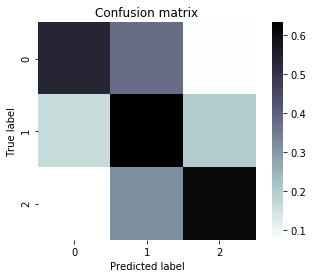

[[1595 1118  239]
 [1814 6912 2208]
 [ 254 1079 2063]]
Opened short order 1  at  2019-09-02 00:00:00 05:15 Price= 1.09915  Takeprofit= 1.0987500000000001  Stoploss= 1.09955  Balance  1000
Closed short order 1  at timeout 2019-09-02 00:00:00 05:30 Price= 1.09909  Balance  1000
Closed short order 1  at takeprofit 2019-09-02 00:00:00 07:15 Price= 1.09863  Balance  1000
Opened long order 100000  at  2019-09-02 00:00:00 09:00 Price= 1.09822  Takeprofit= 1.09862  Stoploss= 1.09782  Balance  1003.3
Closed long order 100000   at stoploss  2019-09-02 00:00:00 09:15 Price= 1.09765  Balance  1003.3
Opened short order 2  at  2019-09-02 00:00:00 09:30 Price= 1.09847  Takeprofit= 1.09807  Stoploss= 1.09887  Balance  998.5999999999999
Closed short order 2  at takeprofit 2019-09-02 00:00:00 09:45 Price= 1.09786  Balance  998.5999999999999
Opened long order 100001  at  2019-09-02 00:00:00 10:30 Price= 1.0978  Takeprofit= 1.0982  Stoploss= 1.0974000000000002  Balance  1001.8999999999999
Closed long orde

array([[1595, 1118,  239],
       [1814, 6912, 2208],
       [ 254, 1079, 2063]])

In [ ]:
validation_predictions = list(classifier.predict(input_fn=predict_validation_input_fn))   
validation_pred_class_id = np.array([item['class_ids'] for item in validation_predictions])

recall, update_op_recall = tf.metrics.recall(validation_targets, validation_pred_class_id)
precision, update_op = tf.metrics.precision(validation_targets, validation_pred_class_id)

with tf.Session() as sess:
  sess.run(tf.local_variables_initializer())
  sess.run(update_op_recall)
  sess.run(update_op)
  print (sess.run(precision))
  print (sess.run(recall))

cm = metrics.confusion_matrix(validation_targets, validation_pred_class_id)
cm_normalized = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
ax = sns.heatmap(cm_normalized, cmap="bone_r")
ax.set_aspect(1)
plt.title("Confusion matrix")
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.show()
print(cm)


df = df_original.copy()
df['date'] = pd.to_datetime(df['date'])
df_from_date_mask = (df['date'] > '2019-09-01')
df = df.loc[df_from_date_mask]

validation_examples_with_targets = validation_examples.copy()
validation_examples_with_targets['close'] = df['close']
#df['open'] = np.roll(df['close'], 1)
validation_examples_with_targets['open'] = df['open']
validation_examples_with_targets['high'] = df['high']
validation_examples_with_targets['low'] = df['low']
validation_examples_with_targets['date'] = df['date']
validation_examples_with_targets['time'] = df['time']
validation_examples_with_targets.loc[:, 'trend'] = validation_pred_class_id

from_date_mask = (validation_examples_with_targets['date'] > '2019-09-01')
validation_examples_with_targets = validation_examples_with_targets.loc[from_date_mask]

balance = evaluate_profit(validation_examples_with_targets,1000,4,-4,0.7,1)
print(balance)
cm

# Model Deployment
Model will now be saved into a tensorflow saved model by calling tf.contrib.saved_model.save_keras_model







In [ ]:
feature_spec = {feature.name: tf.placeholder(tf.float32, shape=[None], name=feature.name) for feature in construct_feature_columns(training_examples,'weight')} 
export_input_fn = tf.estimator.export.build_raw_serving_input_receiver_fn(feature_spec)

classifier.export_savedmodel("./eurusd_M15",serving_input_receiver_fn=export_input_fn)

W0827 19:52:32.063452 140023323031424 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/saved_model/signature_def_utils_impl.py:201: build_tensor_info (from tensorflow.python.saved_model.utils_impl) is deprecated and will be removed in a future version.
Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.utils.build_tensor_info or tf.compat.v1.saved_model.build_tensor_info.
W0827 19:52:32.070389 140023323031424 export_utils.py:182] Export includes no default signature!


b'./eurusd_M15/1566935551'

In [ ]:
!zip -r /content/eurusd_model.zip /content/eurusd_M15

  adding: content/eurusd_M15/ (stored 0%)
  adding: content/eurusd_M15/temp-b'1566935523'/ (stored 0%)
  adding: content/eurusd_M15/1566935551/ (stored 0%)
  adding: content/eurusd_M15/1566935551/saved_model.pb (deflated 90%)
  adding: content/eurusd_M15/1566935551/variables/ (stored 0%)
  adding: content/eurusd_M15/1566935551/variables/variables.index (deflated 32%)
  adding: content/eurusd_M15/1566935551/variables/variables.data-00000-of-00002 (deflated 25%)
  adding: content/eurusd_M15/1566935551/variables/variables.data-00001-of-00002 (deflated 33%)
